# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os
from bs4 import BeautifulSoup

In [2]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 10000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (10000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [3]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [4]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [5]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [6]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [7]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [8]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(9564, 10)

In [10]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

95.64

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [11]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [12]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [13]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(9564, 10)


1    7976
0    1588
Name: Score, dtype: int64

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [17]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [21]:
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [22]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████████| 9564/9564 [00:07<00:00, 1342.71it/s]


In [23]:
preprocessed_reviews[1500]

'chips truly amazing light crisp great tasting nice texture natural low fat sodium need say recently bought bag regular grocery store could not belive taste buds excited saw amazon decided buy case'

In [ ]:
data = preprocessed_reviews

# Creating the vocabolary:

In [32]:
#data = ["this dog is really fast","dog barks on the strangers","I like dog who barks on strangers"]
words = []
all_words = []
for k in data:
    for word in k.split(' '):
        if word not in words:
            words.append(word)    #it will contain all the unique word in the dataset
        all_words.append(word)  #it will containing all the words in the dataset

In [30]:
print("Total number of unique words in thhe dataset: ",len(words))
print("Total words in the dataset: ",len(all_reviews))

Total number of unique words in thhe dataset:  12
Total words in the dataset:  17


In [37]:
# initializing the dictionary with all unique values
dictionary = {}
for k in all_reviews:
        dictionary[k] = 0 

In [38]:
# initializing the dictionary with all unique values
import operator
dictionary = {}
for k in all_words:
        dictionary[k] = 0 #initializing the dictionary with 0
for k in all_words:
    dictionary[k] = dictionary[k]+1   # creating the dictionary from the dataset
sorted_dict = sorted(dictionary.items(), key=operator.itemgetter(1))  # sorting the dictionary according to the number of times a word has occured

In [39]:
import operator
sorted_dict = sorted(dictionary.items(), key=operator.itemgetter(1))  # sorting the dictionary

In [41]:
sd = sorted_dict[::-1]   # containing all the words count in dec order
sd

[('dog', 3),
 ('strangers', 2),
 ('on', 2),
 ('barks', 2),
 ('who', 1),
 ('like', 1),
 ('I', 1),
 ('the', 1),
 ('fast', 1),
 ('really', 1),
 ('is', 1),
 ('this', 1)]

In [17]:
#sd = sorted_dict[: :-1]
print("TOP WORDS\t\t\t"+"FREQUENCY")
count = 0
for d in sd:
    if count ==10:
        break
    print(d[0],"\t\t\t\t",d[1])
    count = count+1  

TOP WORDS			FREQUENCY
dog 				 3
strangers 				 2
on 				 2
barks 				 2
who 				 1
like 				 1
I 				 1
the 				 1
fast 				 1
really 				 1


In [18]:
final_words = []
for word in sd:
    final_words.append(word[0])

In [44]:
new_data = []   # it will contain the numerical representation of the text data
final_words = []  #it will contain the word in the decresing order of occurance
for word in sd:
    final_words.append(word[0])
for f in data:
    l = []
    for k in f.split(' '):
        if k in final_words:
            #finding the index of the word
            ind = final_words.index(k)
            l.append(ind+1)
    #updating the text sentence
    new_data.append(l)

In [45]:
new_data

[[12, 1, 11, 10, 9], [1, 4, 3, 8, 2], [7, 6, 1, 5, 4, 3, 2]]

In [40]:
# deviding the data into train and test
y = final['Score'].values
y_train=y[0:6000]
x_train=new_reviews[0:6000]
y_test=y[6000:]
x_test=new_reviews[6000:]

In [42]:
# padding the dataset
from keras.preprocessing import sequence
#you can change max length according to your dataset size
max_review_length = 600
x_train=sequence.pad_sequences(x_train,maxlen=max_review_length)
x_test=sequence.pad_sequences(x_test,maxlen=max_review_length)
print("Training data Shape",x_train.shape)

Using TensorFlow backend.


Training data Shape (6000, 600)


# 1st architecture

In [43]:
# fix random seed for reproducibility
numpy.random.seed(7)
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

In [44]:
# create the model
embedding_vecor_length = 32
top_words = 18264
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=len(x_train[0])))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 600, 32)           584448    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 637,749
Trainable params: 637,749
Non-trainable params: 0
_________________________________________________________________
None


In [45]:
history = model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))

Instructions for updating:
Use tf.cast instead.
Train on 6000 samples, validate on 3564 samples
Epoch 1/10
6000/6000 [==============================] - ETA: 3:01 - loss: 0.6936 - acc: 0.390 - ETA: 2:07 - loss: 0.6907 - acc: 0.648 - ETA: 1:45 - loss: 0.6882 - acc: 0.729 - ETA: 1:35 - loss: 0.6857 - acc: 0.757 - ETA: 1:29 - loss: 0.6827 - acc: 0.778 - ETA: 1:26 - loss: 0.6794 - acc: 0.789 - ETA: 1:22 - loss: 0.6776 - acc: 0.781 - ETA: 1:19 - loss: 0.6748 - acc: 0.777 - ETA: 1:16 - loss: 0.6697 - acc: 0.783 - ETA: 1:14 - loss: 0.6627 - acc: 0.790 - ETA: 1:11 - loss: 0.6550 - acc: 0.794 - ETA: 1:10 - loss: 0.6424 - acc: 0.800 - ETA: 1:08 - loss: 0.6337 - acc: 0.799 - ETA: 1:08 - loss: 0.6275 - acc: 0.800 - ETA: 1:07 - loss: 0.6220 - acc: 0.800 - ETA: 1:06 - loss: 0.6070 - acc: 0.804 - ETA: 1:05 - loss: 0.6063 - acc: 0.799 - ETA: 1:03 - loss: 0.5980 - acc: 0.802 - ETA: 1:02 - loss: 0.5927 - acc: 0.802 - ETA: 1:01 - loss: 0.5848 - acc: 0.806 - ETA: 1:00 - loss: 0.5817 - acc: 0.805 - ETA: 1:0

6000/6000 [==============================] - ETA: 1:16 - loss: 0.0360 - acc: 0.984 - ETA: 1:11 - loss: 0.0271 - acc: 0.992 - ETA: 1:08 - loss: 0.0290 - acc: 0.994 - ETA: 1:08 - loss: 0.0363 - acc: 0.992 - ETA: 1:07 - loss: 0.0320 - acc: 0.993 - ETA: 1:06 - loss: 0.0313 - acc: 0.992 - ETA: 1:06 - loss: 0.0293 - acc: 0.993 - ETA: 1:05 - loss: 0.0277 - acc: 0.994 - ETA: 1:05 - loss: 0.0302 - acc: 0.989 - ETA: 1:04 - loss: 0.0299 - acc: 0.990 - ETA: 1:04 - loss: 0.0301 - acc: 0.990 - ETA: 1:03 - loss: 0.0295 - acc: 0.990 - ETA: 1:03 - loss: 0.0322 - acc: 0.988 - ETA: 1:02 - loss: 0.0311 - acc: 0.988 - ETA: 1:02 - loss: 0.0302 - acc: 0.989 - ETA: 1:01 - loss: 0.0307 - acc: 0.989 - ETA: 1:00 - loss: 0.0324 - acc: 0.987 - ETA: 1:00 - loss: 0.0316 - acc: 0.987 - ETA: 59s - loss: 0.0310 - acc: 0.988 - ETA: 58s - loss: 0.0307 - acc: 0.98 - ETA: 58s - loss: 0.0305 - acc: 0.98 - ETA: 57s - loss: 0.0296 - acc: 0.99 - ETA: 56s - loss: 0.0291 - acc: 0.99 - ETA: 56s - loss: 0.0288 - acc: 0.99 - ETA: 5

6000/6000 [==============================] - ETA: 1:16 - loss: 0.0029 - acc: 1.000 - ETA: 1:17 - loss: 0.0026 - acc: 1.000 - ETA: 1:16 - loss: 0.0055 - acc: 1.000 - ETA: 1:13 - loss: 0.0046 - acc: 1.000 - ETA: 1:09 - loss: 0.0039 - acc: 1.000 - ETA: 1:05 - loss: 0.0035 - acc: 1.000 - ETA: 1:03 - loss: 0.0034 - acc: 1.000 - ETA: 1:02 - loss: 0.0031 - acc: 1.000 - ETA: 1:02 - loss: 0.0030 - acc: 1.000 - ETA: 1:02 - loss: 0.0028 - acc: 1.000 - ETA: 1:00 - loss: 0.0030 - acc: 1.000 - ETA: 59s - loss: 0.0029 - acc: 1.000 - ETA: 57s - loss: 0.0032 - acc: 1.00 - ETA: 56s - loss: 0.0030 - acc: 1.00 - ETA: 55s - loss: 0.0029 - acc: 1.00 - ETA: 55s - loss: 0.0028 - acc: 1.00 - ETA: 54s - loss: 0.0028 - acc: 1.00 - ETA: 53s - loss: 0.0029 - acc: 1.00 - ETA: 52s - loss: 0.0029 - acc: 1.00 - ETA: 51s - loss: 0.0028 - acc: 1.00 - ETA: 50s - loss: 0.0029 - acc: 1.00 - ETA: 49s - loss: 0.0028 - acc: 1.00 - ETA: 49s - loss: 0.0027 - acc: 1.00 - ETA: 48s - loss: 0.0026 - acc: 1.00 - ETA: 48s - loss: 0.0

In [46]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.44%


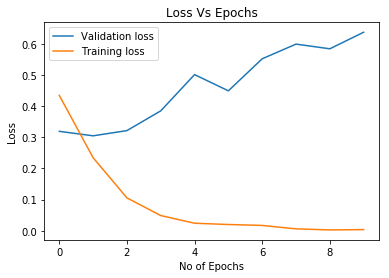

In [49]:
val_loss=history.history['val_loss']
loss=history.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.legend(["Validation loss","Training loss"])
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.show()

# 2nd Architecture
#### only taking top 5000 points

In [50]:
# tsking top 5000 points
top_5000 = []
count = 0
for d in sd:
    if count ==5000:
        break
    top_5000.append(d)
    count = count+1

In [51]:
top_5000[0:11]

[('not', 9474),
 ('like', 3897),
 ('good', 3298),
 ('great', 2878),
 ('taste', 2680),
 ('coffee', 2662),
 ('one', 2622),
 ('would', 2480),
 ('product', 2438),
 ('flavor', 2307),
 ('love', 2008)]

In [52]:
final_words = []
for word in top_5000:
    final_words.append(word[0])

In [53]:
new_reviews = []   # it will contain the numerical representation of the reviews
for f in preprocessed_reviews:
    l = []
    for k in f.split(' '):
        if k in final_words:
            ind = final_words.index(k)
            l.append(ind+1)
    new_reviews.append(l)

In [54]:
# deviding the data into train and test
y = final['Score'].values
y_train=y[0:6000]
x_train=new_reviews[0:6000]
y_test=y[6000:]
x_test=new_reviews[6000:]

In [55]:
# padding the dataset
max_review_length = 600
x_train=sequence.pad_sequences(x_train,maxlen=max_review_length)
x_test=sequence.pad_sequences(x_test,maxlen=max_review_length)
print("Training data Shape",x_train.shape)

Training data Shape (6000, 600)


In [56]:
# create the model
embedding_vecor_length = 32
top_words = 18264
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=len(x_train[0])))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 600, 32)           584448    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 637,749
Trainable params: 637,749
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
history = model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))

Train on 6000 samples, validate on 3564 samples
Epoch 1/10
6000/6000 [==============================] - ETA: 3:22 - loss: 0.6926 - acc: 0.531 - ETA: 2:15 - loss: 0.6906 - acc: 0.671 - ETA: 1:50 - loss: 0.6878 - acc: 0.744 - ETA: 1:38 - loss: 0.6855 - acc: 0.765 - ETA: 1:31 - loss: 0.6834 - acc: 0.771 - ETA: 1:26 - loss: 0.6796 - acc: 0.786 - ETA: 1:22 - loss: 0.6759 - acc: 0.792 - ETA: 1:18 - loss: 0.6714 - acc: 0.798 - ETA: 1:16 - loss: 0.6679 - acc: 0.793 - ETA: 1:14 - loss: 0.6618 - acc: 0.792 - ETA: 1:13 - loss: 0.6510 - acc: 0.798 - ETA: 1:11 - loss: 0.6416 - acc: 0.795 - ETA: 1:09 - loss: 0.6235 - acc: 0.800 - ETA: 1:06 - loss: 0.6169 - acc: 0.802 - ETA: 1:03 - loss: 0.5936 - acc: 0.810 - ETA: 1:01 - loss: 0.5960 - acc: 0.807 - ETA: 59s - loss: 0.5845 - acc: 0.810 - ETA: 57s - loss: 0.5758 - acc: 0.81 - ETA: 55s - loss: 0.5660 - acc: 0.81 - ETA: 53s - loss: 0.5609 - acc: 0.81 - ETA: 51s - loss: 0.5525 - acc: 0.81 - ETA: 49s - loss: 0.5479 - acc: 0.82 - ETA: 48s - loss: 0.5424 - a

6000/6000 [==============================] - ETA: 42s - loss: 0.0587 - acc: 0.98 - ETA: 45s - loss: 0.0697 - acc: 0.97 - ETA: 42s - loss: 0.0564 - acc: 0.98 - ETA: 41s - loss: 0.0475 - acc: 0.98 - ETA: 40s - loss: 0.0449 - acc: 0.98 - ETA: 39s - loss: 0.0568 - acc: 0.98 - ETA: 38s - loss: 0.0529 - acc: 0.98 - ETA: 37s - loss: 0.0530 - acc: 0.98 - ETA: 37s - loss: 0.0486 - acc: 0.98 - ETA: 37s - loss: 0.0490 - acc: 0.98 - ETA: 37s - loss: 0.0486 - acc: 0.98 - ETA: 37s - loss: 0.0496 - acc: 0.98 - ETA: 37s - loss: 0.0473 - acc: 0.98 - ETA: 36s - loss: 0.0474 - acc: 0.98 - ETA: 36s - loss: 0.0456 - acc: 0.98 - ETA: 36s - loss: 0.0454 - acc: 0.98 - ETA: 36s - loss: 0.0446 - acc: 0.98 - ETA: 35s - loss: 0.0454 - acc: 0.98 - ETA: 35s - loss: 0.0459 - acc: 0.98 - ETA: 34s - loss: 0.0481 - acc: 0.98 - ETA: 34s - loss: 0.0493 - acc: 0.98 - ETA: 34s - loss: 0.0480 - acc: 0.98 - ETA: 33s - loss: 0.0515 - acc: 0.98 - ETA: 33s - loss: 0.0520 - acc: 0.98 - ETA: 33s - loss: 0.0502 - acc: 0.98 - ETA: 

6000/6000 [==============================] - ETA: 45s - loss: 0.0043 - acc: 1.00 - ETA: 42s - loss: 0.0030 - acc: 1.00 - ETA: 42s - loss: 0.0028 - acc: 1.00 - ETA: 40s - loss: 0.0027 - acc: 1.00 - ETA: 39s - loss: 0.0025 - acc: 1.00 - ETA: 38s - loss: 0.0024 - acc: 1.00 - ETA: 37s - loss: 0.0040 - acc: 1.00 - ETA: 37s - loss: 0.0039 - acc: 1.00 - ETA: 36s - loss: 0.0039 - acc: 1.00 - ETA: 36s - loss: 0.0038 - acc: 1.00 - ETA: 36s - loss: 0.0036 - acc: 1.00 - ETA: 35s - loss: 0.0035 - acc: 1.00 - ETA: 35s - loss: 0.0033 - acc: 1.00 - ETA: 35s - loss: 0.0031 - acc: 1.00 - ETA: 34s - loss: 0.0034 - acc: 1.00 - ETA: 34s - loss: 0.0048 - acc: 0.99 - ETA: 34s - loss: 0.0046 - acc: 0.99 - ETA: 33s - loss: 0.0045 - acc: 0.99 - ETA: 33s - loss: 0.0048 - acc: 0.99 - ETA: 32s - loss: 0.0051 - acc: 0.99 - ETA: 32s - loss: 0.0050 - acc: 0.99 - ETA: 32s - loss: 0.0051 - acc: 0.99 - ETA: 31s - loss: 0.0051 - acc: 0.99 - ETA: 31s - loss: 0.0049 - acc: 0.99 - ETA: 30s - loss: 0.0048 - acc: 0.99 - ETA: 

In [58]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.12%


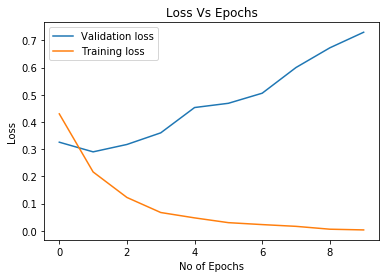

In [59]:
val_loss=history.history['val_loss']
loss=history.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.legend(["Validation loss","Training loss"])
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.show()

In [60]:
history.history['val_acc']

[0.8526936024929137,
 0.8787878785871898,
 0.8843995513338031,
 0.879910213511132,
 0.871773288239266,
 0.8765432096758542,
 0.8773849607851903,
 0.87457912484671,
 0.8731762067771253,
 0.8712121214797066]

# 3rd Architecture

In [62]:
# create the model
from keras.layers import Dense,Dropout
embedding_vecor_length = 32
top_words = 18264
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=len(x_train[0])))
model.add(LSTM(100,return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())
#Refer: https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 600, 32)           584448    
_________________________________________________________________
lstm_5 (LSTM)                (None, 600, 100)          53200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 718,149
Trainable params: 718,149
Non-trainable params: 0
_________________________________________________________________
None


In [63]:
history = model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))

Train on 6000 samples, validate on 3564 samples
Epoch 1/10
6000/6000 [==============================] - ETA: 4:09 - loss: 0.6924 - acc: 0.656 - ETA: 2:46 - loss: 0.6885 - acc: 0.750 - ETA: 2:18 - loss: 0.6838 - acc: 0.776 - ETA: 2:04 - loss: 0.6792 - acc: 0.781 - ETA: 1:56 - loss: 0.6730 - acc: 0.787 - ETA: 1:50 - loss: 0.6612 - acc: 0.799 - ETA: 1:46 - loss: 0.6452 - acc: 0.812 - ETA: 1:43 - loss: 0.6241 - acc: 0.816 - ETA: 1:41 - loss: 0.6034 - acc: 0.821 - ETA: 1:38 - loss: 0.5956 - acc: 0.821 - ETA: 1:36 - loss: 0.5875 - acc: 0.823 - ETA: 1:34 - loss: 0.5670 - acc: 0.829 - ETA: 1:33 - loss: 0.5548 - acc: 0.830 - ETA: 1:31 - loss: 0.5464 - acc: 0.830 - ETA: 1:30 - loss: 0.5356 - acc: 0.832 - ETA: 1:28 - loss: 0.5266 - acc: 0.835 - ETA: 1:27 - loss: 0.5213 - acc: 0.834 - ETA: 1:25 - loss: 0.5161 - acc: 0.835 - ETA: 1:24 - loss: 0.5135 - acc: 0.833 - ETA: 1:22 - loss: 0.5078 - acc: 0.835 - ETA: 1:21 - loss: 0.5087 - acc: 0.834 - ETA: 1:19 - loss: 0.5074 - acc: 0.833 - ETA: 1:17 - loss

6000/6000 [==============================] - ETA: 1:47 - loss: 0.0578 - acc: 0.968 - ETA: 1:47 - loss: 0.0314 - acc: 0.984 - ETA: 1:45 - loss: 0.0242 - acc: 0.989 - ETA: 1:45 - loss: 0.0193 - acc: 0.992 - ETA: 1:44 - loss: 0.0186 - acc: 0.993 - ETA: 1:43 - loss: 0.0211 - acc: 0.989 - ETA: 1:41 - loss: 0.0195 - acc: 0.991 - ETA: 1:39 - loss: 0.0193 - acc: 0.990 - ETA: 1:37 - loss: 0.0221 - acc: 0.989 - ETA: 1:35 - loss: 0.0208 - acc: 0.990 - ETA: 1:34 - loss: 0.0208 - acc: 0.990 - ETA: 1:32 - loss: 0.0241 - acc: 0.989 - ETA: 1:31 - loss: 0.0254 - acc: 0.989 - ETA: 1:30 - loss: 0.0245 - acc: 0.990 - ETA: 1:29 - loss: 0.0232 - acc: 0.990 - ETA: 1:28 - loss: 0.0224 - acc: 0.991 - ETA: 1:27 - loss: 0.0340 - acc: 0.988 - ETA: 1:26 - loss: 0.0333 - acc: 0.987 - ETA: 1:25 - loss: 0.0328 - acc: 0.987 - ETA: 1:24 - loss: 0.0356 - acc: 0.985 - ETA: 1:23 - loss: 0.0348 - acc: 0.986 - ETA: 1:22 - loss: 0.0343 - acc: 0.987 - ETA: 1:21 - loss: 0.0336 - acc: 0.987 - ETA: 1:20 - loss: 0.0327 - acc: 0.9

6000/6000 [==============================] - ETA: 1:51 - loss: 0.0299 - acc: 1.000 - ETA: 1:46 - loss: 0.0315 - acc: 0.992 - ETA: 1:43 - loss: 0.0290 - acc: 0.994 - ETA: 1:41 - loss: 0.0290 - acc: 0.996 - ETA: 1:39 - loss: 0.0374 - acc: 0.990 - ETA: 1:37 - loss: 0.0383 - acc: 0.989 - ETA: 1:35 - loss: 0.0374 - acc: 0.988 - ETA: 1:34 - loss: 0.0353 - acc: 0.988 - ETA: 1:32 - loss: 0.0321 - acc: 0.989 - ETA: 1:31 - loss: 0.0295 - acc: 0.990 - ETA: 1:30 - loss: 0.0314 - acc: 0.990 - ETA: 1:29 - loss: 0.0295 - acc: 0.990 - ETA: 1:28 - loss: 0.0281 - acc: 0.991 - ETA: 1:28 - loss: 0.0263 - acc: 0.992 - ETA: 1:27 - loss: 0.0247 - acc: 0.992 - ETA: 1:26 - loss: 0.0233 - acc: 0.993 - ETA: 1:25 - loss: 0.0299 - acc: 0.990 - ETA: 1:25 - loss: 0.0284 - acc: 0.991 - ETA: 1:24 - loss: 0.0270 - acc: 0.991 - ETA: 1:23 - loss: 0.0273 - acc: 0.991 - ETA: 1:22 - loss: 0.0261 - acc: 0.991 - ETA: 1:21 - loss: 0.0284 - acc: 0.991 - ETA: 1:20 - loss: 0.0277 - acc: 0.991 - ETA: 1:19 - loss: 0.0267 - acc: 0.9

In [64]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.40%


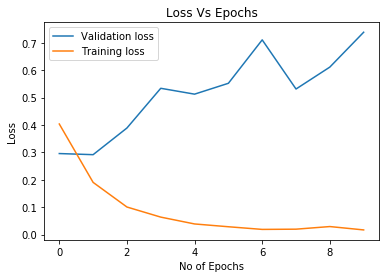

In [65]:
val_loss=history.history['val_loss']
loss=history.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.legend(["Validation loss","Training loss"])
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.show()

## 4th architecture 


In [66]:
# create the model
embedding_vecor_length = 32
top_words = 18264
model = Sequential()
model.add(Embedding(top_words, embedding_vecor_length, input_length=len(x_train[0])))
model.add(LSTM(32,return_sequences=True))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.75))
model.add(LSTM(32))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 600, 32)           584448    
_________________________________________________________________
lstm_7 (LSTM)                (None, 600, 32)           8320      
_________________________________________________________________
lstm_8 (LSTM)                (None, 600, 64)           24832     
_________________________________________________________________
dropout_2 (Dropout)          (None, 600, 64)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 630,049
Trainable params: 630,049
Non-trainable params: 0
_________________________________________________________________
None

In [67]:
history = model.fit(x_train, y_train, nb_epoch=10, batch_size=64,validation_data=(x_test,y_test))

Train on 6000 samples, validate on 3564 samples
Epoch 1/10
6000/6000 [==============================] - ETA: 4:03 - loss: 0.6936 - acc: 0.390 - ETA: 2:37 - loss: 0.6906 - acc: 0.656 - ETA: 2:09 - loss: 0.6882 - acc: 0.718 - ETA: 1:54 - loss: 0.6855 - acc: 0.750 - ETA: 1:45 - loss: 0.6828 - acc: 0.762 - ETA: 1:38 - loss: 0.6803 - acc: 0.765 - ETA: 1:33 - loss: 0.6775 - acc: 0.765 - ETA: 1:28 - loss: 0.6722 - acc: 0.777 - ETA: 1:24 - loss: 0.6655 - acc: 0.789 - ETA: 1:21 - loss: 0.6585 - acc: 0.798 - ETA: 1:19 - loss: 0.6497 - acc: 0.805 - ETA: 1:16 - loss: 0.6432 - acc: 0.803 - ETA: 1:14 - loss: 0.6332 - acc: 0.805 - ETA: 1:12 - loss: 0.6243 - acc: 0.804 - ETA: 1:10 - loss: 0.6157 - acc: 0.804 - ETA: 1:09 - loss: 0.6090 - acc: 0.803 - ETA: 1:07 - loss: 0.6070 - acc: 0.802 - ETA: 1:06 - loss: 0.5940 - acc: 0.806 - ETA: 1:04 - loss: 0.5874 - acc: 0.807 - ETA: 1:03 - loss: 0.5722 - acc: 0.813 - ETA: 1:02 - loss: 0.5647 - acc: 0.814 - ETA: 1:00 - loss: 0.5531 - acc: 0.818 - ETA: 59s - loss:

6000/6000 [==============================] - ETA: 1:16 - loss: 0.0861 - acc: 0.968 - ETA: 1:16 - loss: 0.0529 - acc: 0.984 - ETA: 1:14 - loss: 0.0402 - acc: 0.989 - ETA: 1:13 - loss: 0.0407 - acc: 0.988 - ETA: 1:13 - loss: 0.0383 - acc: 0.990 - ETA: 1:12 - loss: 0.0344 - acc: 0.992 - ETA: 1:11 - loss: 0.0311 - acc: 0.993 - ETA: 1:10 - loss: 0.0300 - acc: 0.994 - ETA: 1:09 - loss: 0.0311 - acc: 0.991 - ETA: 1:07 - loss: 0.0396 - acc: 0.985 - ETA: 1:06 - loss: 0.0370 - acc: 0.987 - ETA: 1:05 - loss: 0.0368 - acc: 0.987 - ETA: 1:04 - loss: 0.0353 - acc: 0.988 - ETA: 1:03 - loss: 0.0358 - acc: 0.987 - ETA: 1:02 - loss: 0.0385 - acc: 0.986 - ETA: 1:01 - loss: 0.0373 - acc: 0.987 - ETA: 1:00 - loss: 0.0370 - acc: 0.987 - ETA: 59s - loss: 0.0412 - acc: 0.987 - ETA: 59s - loss: 0.0398 - acc: 0.98 - ETA: 58s - loss: 0.0408 - acc: 0.98 - ETA: 57s - loss: 0.0395 - acc: 0.98 - ETA: 57s - loss: 0.0385 - acc: 0.98 - ETA: 56s - loss: 0.0401 - acc: 0.98 - ETA: 55s - loss: 0.0401 - acc: 0.98 - ETA: 54s

6000/6000 [==============================] - ETA: 1:01 - loss: 0.0040 - acc: 1.000 - ETA: 1:06 - loss: 0.0102 - acc: 0.992 - ETA: 1:07 - loss: 0.0078 - acc: 0.994 - ETA: 1:06 - loss: 0.0362 - acc: 0.992 - ETA: 1:05 - loss: 0.0296 - acc: 0.993 - ETA: 1:05 - loss: 0.0254 - acc: 0.994 - ETA: 1:04 - loss: 0.0222 - acc: 0.995 - ETA: 1:03 - loss: 0.0201 - acc: 0.996 - ETA: 1:03 - loss: 0.0181 - acc: 0.996 - ETA: 1:02 - loss: 0.0166 - acc: 0.996 - ETA: 1:01 - loss: 0.0164 - acc: 0.997 - ETA: 1:01 - loss: 0.0152 - acc: 0.997 - ETA: 1:00 - loss: 0.0163 - acc: 0.996 - ETA: 59s - loss: 0.0154 - acc: 0.996 - ETA: 58s - loss: 0.0145 - acc: 0.99 - ETA: 57s - loss: 0.0138 - acc: 0.99 - ETA: 57s - loss: 0.0171 - acc: 0.99 - ETA: 56s - loss: 0.0185 - acc: 0.99 - ETA: 55s - loss: 0.0184 - acc: 0.99 - ETA: 55s - loss: 0.0224 - acc: 0.99 - ETA: 54s - loss: 0.0215 - acc: 0.99 - ETA: 53s - loss: 0.0207 - acc: 0.99 - ETA: 52s - loss: 0.0207 - acc: 0.99 - ETA: 52s - loss: 0.0201 - acc: 0.99 - ETA: 51s - loss:

In [68]:
# Final evaluation of the model
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 86.76%


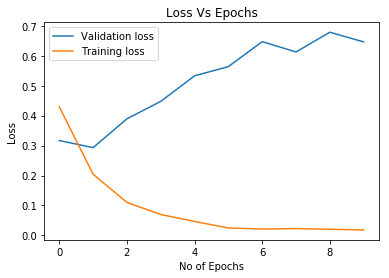

In [69]:
val_loss=history.history['val_loss']
loss=history.history['loss']
plt.plot(val_loss)
plt.plot(loss)
plt.legend(["Validation loss","Training loss"])
plt.xlabel("No of Epochs")
plt.ylabel("Loss")
plt.title("Loss Vs Epochs")
plt.show()

In [73]:
from prettytable import PrettyTable
x=PrettyTable()
x.field_names=['No of LSTM','units','Accuracy',"comment"]
x.add_row(['1','100','  85.44',"with all words"])
x.add_row(['1','100','  87.12%','top 5000 words'])
x.add_row(['2','100,100',' 87.40%',"top 5000 words"])
x.add_row(['3','32,64,32',' 86.76%',"top 5000 wrods"])
print(x)

+------------+----------+----------+----------------+
| No of LSTM |  units   | Accuracy |    comment     |
+------------+----------+----------+----------------+
|     1      |   100    |   85.44  | with all words |
|     1      |   100    |   87.12% | top 5000 words |
|     2      | 100,100  |  87.40%  | top 5000 words |
|     3      | 32,64,32 |  86.76%  | top 5000 wrods |
+------------+----------+----------+----------------+


Conclusion : 
1. From the above table we can see that we are getting maximum accuracy for 3rd architecture.
2. In all the architecture as the number of epochs increases model starts to overfitt, as with epoch the gap between train and cv loss increases.    

Steps taken :
1. Load the dataset.
2. Preprocess the dataset.
3. Create the vocabulary.
4. Create the dictionary.
5. Convert the given dataset into numerical representation.
6. Define the architecture of the LSTM model.
7. Complie the model.
8. Execute the model for 10 epochs.
9. Plot the graph between train and cross validation accuracy.
10. use different-different architecture.